# Inference on 3D Scenes using Open3D

Mount Drive

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Install open3d, tqdm, and ipympl

In [4]:
!pip install open3d #3d stuff
!pip install tqdm # loading bars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 422.5 MB 38 kB/s 
     |████████████████████████████████| 3.2 MB 59.5 MB/s 
     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 9.9 MB 42.8 MB/s 
     |████████████████████████████████| 1.6 MB 47.1 MB/s 
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.7.0
    Uninstalling nbformat-5.7.0:
      Successfully uninstalled nbformat-5.7.0
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 510 kB 5.2 MB/s 
     |████████████████████████████████| 9.4 MB 71.5 MB/s 
     |████████████████████████████████| 295 kB 68.1 MB/s 
     |████████████████████████████████| 965 kB 61.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [5]:
!pip install Pillow==9.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 5.3 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.3.0
    Uninstalling Pillow-9.3.0:
      Successfully uninstalled Pillow-9.3.0


In [6]:
from google.colab import output
output.enable_custom_widget_manager()

Note: Helper Functions defined in "helpers.py"

In [4]:
import os
os.environ['OPEN3D_CPU_RENDERING'] = 'true'

import open3d as o3d
import open3d.visualization as viz
import open3d.visualization.rendering as rendering
from matplotlib import pyplot as plt
import numpy as np

# Importing Helper Functions
import sys, os
sys.path.append('drive/MyDrive/Colab Notebooks/9.66 Final Project') # may not be needed depending where you're running this
import helpers

mesh = o3d.geometry.TriangleMesh # less typing

# Basic Scene Inference (sphere and ground plane)

## Ground Truth Image Generation

In [3]:
sd = (1280, 720)
low_quality = (256, 144)
very_low = (128, 72)
basic_render = rendering.OffscreenRenderer(*very_low) # choose quality (wait times get very high very quickly)

[Open3D INFO] EGL headless mode enabled.


In [4]:
radius = .7

sphere_mesh = mesh.create_sphere(radius)
sphere_mesh.compute_vertex_normals(normalized=True) # compute normals for rendering

ground = helpers.make_plane(3)
ground.translate([0, -radius, 0], relative = False) # "stick" plane to bottom of the ball


basic_render.scene.clear_geometry()

#materials
base_material = helpers.create_material()

#add geometry to scene
basic_render.scene.add_geometry("ball", sphere_mesh, base_material) #adds geometry (i.e. from a primitive object)
basic_render.scene.add_geometry("ground", ground, base_material) #adds geometry (i.e. from a primitive object)
basic_render.scene.set_lighting(rendering.Open3DScene.LightingProfile.MED_SHADOWS, (0.577, -0.577, -0.577)) # Sunlight Direction is what we'll be doing inference over

camera_pos = np.array([2,0,1.75])
zoom = .5

basic_render.setup_camera(30, [0,0,0], camera_pos / zoom, [0,1,0]) # sets up camera in (vertical_FOV, center, eye, up) format
basic_render.scene.set_background(helpers.convert_to_float([88, 179, 191, 255]))

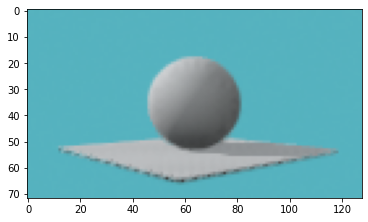

In [5]:
basic_img = basic_render.render_to_image()
plt.imshow(basic_img)

## Inference over Sunlight Direction

What if we make the sunlight come from a random direction?

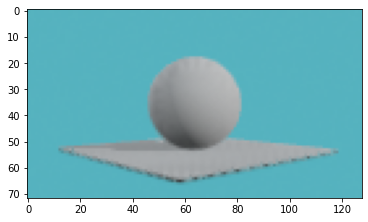

In [6]:
import random
direction = tuple(random.uniform(-np.pi, np.pi) for _ in range(3))
basic_render.scene.set_lighting(rendering.Open3DScene.LightingProfile.MED_SHADOWS, direction)
random_img = basic_render.render_to_image()
plt.imshow(random_img)

In [7]:
helpers.img_diff(basic_img, random_img)

1939012

### Enumeration Method

[Multivariate Normal Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html)

In [8]:
from scipy.stats import multivariate_normal as mult_norm

def gaussian_compare(observed, baseline, scale = 1, log = False):
  """
  Returns product of gaussian distributions at each element at `observed` centered at each element in `baseline`.
  (also known as the multivariate normal distribution centered at `baseline`)
  """
  if log:
    return mult_norm.logpdf(observed.ravel(), mean = baseline.ravel(), cov = scale) 
  
  return mult_norm.pdf(observed.ravel(), mean = baseline.ravel(), cov = scale)

def gauss_image_likelihood(observed, truth, scale = 1, log = False, grayscale = False):
  """
  Image Likelihood on RGB Images is the product of Gaussian distributions on each of the R G and B values at each pixel.
  `grayscale` determines if image RGB values are averaged before comparing.
  `log` determines if log likelihood is computed instead of standard likelihood.
  """
  o_arr = np.asarray(observed)
  t_arr = np.asarray(truth)

  if grayscale:
    o_arr = np.average(o_arr, 2)
    t_arr = np.average(t_arr, 2)
  
  if log:
    out = 0
    update = lambda x, y: x + y

  else:
    out = 1
    update = lambda x, y: x * y

  for i in range(o_arr.shape[0]): # iterate over rows to save memory
    out = update(out, gaussian_compare(o_arr[i], t_arr[i], scale = scale, log = log))
  
  return out

In [9]:
np.asarray(basic_img)
gauss_image_likelihood(basic_img, basic_img, scale = 1, grayscale = True, log = True)

-8468.93752201427

In [10]:
from tqdm.notebook import tqdm

def sunlight_enumerate(env, steps, target, score_func):
  """
  Enumerating over all possible sunlight positions with interval `steps` to find the "best" sunlight position.
  """
  lower, upper = -1, 1
  start = np.asarray([lower, lower, lower]) # start in the bottom left corner of the grid
  best_state = (start, score_func(env, start, target))
  
  grid_ax = np.linspace(lower, upper, steps) # create a grid
  
  #enumeration of grid
  for x in tqdm(grid_ax):
    for y in grid_ax:
      for z in grid_ax:
        proposed = [x,y,z]
        prop_score = score_func(env, [x,y,z], target) # score the proposal
        if prop_score > best_state[1]: # get max
          best_state = (proposed, prop_score)
  
  return best_state

In [11]:
def render_sun_dir(env, dir):
  """
  Renders an OffScreenRenderer `env` with sun direction `dir` (Medium Shadows).
  """
  env.scene.set_lighting(rendering.Open3DScene.LightingProfile.MED_SHADOWS, dir)
  return env.render_to_image()

def sun_likelihood(env, dir, target, grayscale = True, log = True):
  """
  Likelihood function to compute how different a scene's direction is from the target.
  This doesn't really return a probablity since it's not between 0 and 1, but it's close enough.
  """
  return gauss_image_likelihood(render_sun_dir(env, dir), target, grayscale = grayscale, log = log)

In [12]:
guess_1 = sunlight_enumerate(basic_render, 3, basic_img, sun_likelihood)

  0%|          | 0/3 [00:00<?, ?it/s]

Guessed Sunlight Direction: [1.0, -1.0, -1.0], Score: -10056.548633125367


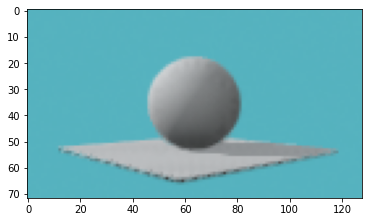

In [13]:
print(f"Guessed Sunlight Direction: {guess_1[0]}, Score: {guess_1[1]}")
plt.imshow(render_sun_dir(basic_render, guess_1[0])) # hey, it works!

Generate Another Image:

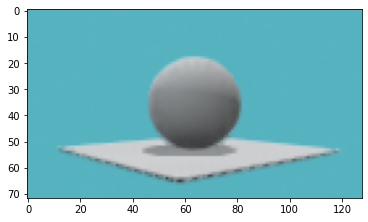

In [367]:
basic_img_2 = render_sun_dir(basic_render, [.1, -.9, .2])
plt.imshow(basic_img_2)

  0%|          | 0/10 [00:00<?, ?it/s]

Guessed Sunlight Direction: [0.11111111111111116, -0.7777777777777778, 0.11111111111111116], Score: -22578.048633125363


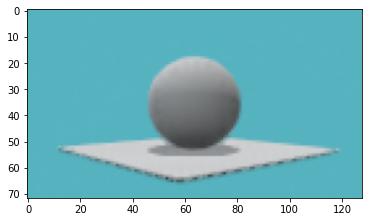

In [366]:
guess_2 = sunlight_enumerate(basic_render, 10, basic_img_2, sun_likelihood)

print(f"Guessed Sunlight Direction: {guess_2[0]}, Score: {guess_2[1]}")
plt.imshow(render_sun_dir(basic_render, guess_2[0])) # works again, but takes a long time even with just 10 steps (runs in O(x^3))

 ### Using Metropolis Hastings to recover the ground truth image.

In [16]:
import scipy.stats

def create_normal_prior(lower = -1, upper = 1, mu_vec = np.zeros(3), sigma = .1):
  # get 3 values from a truncated normal distribution centered at mu, std. deviation sigma, and with bounds higher and upper
  def sample_prior(mu_vec = mu_vec, sigma = .1):
    out = []
    for mu in np.asarray(mu_vec).ravel():
      # get output from truncated normal distribution for each mean in mu_vec
      out.append(scipy.stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=1))
    return np.asarray(out).ravel()

  return sample_prior

In [368]:
from tqdm.notebook import tqdm # high-quality waiting

def sunlight_mcmc(iterations:int, transition_func, likelihood, env, target:o3d.geometry.Image, condition, burn_in = 0):
  """
  Does MCMC over possible sunlight positions, using a `prior` and `likelihood` function.
  Uses the passed in `env`, an Open3D OffScreenRenderer.
  Only the proportion of data after `burn_in` is included.
  """
  states = []
  current = np.random.uniform(-1, 1, size = 3)
  curr_score = likelihood(env, current, target)

  
  #initialize to a state where `condition` is true
  print("Initializing...")
  for i in tqdm(range(iterations)):
    if condition(curr_score):
      break
    iterations -= 1
    current = np.random.uniform(-1, 1, size = 3) # get a new random sample
    curr_score = likelihood(env, current, target)
  
  print("Done initializing!")

  for i in tqdm(range(iterations)):
    states.append((current, curr_score))
    
    # move = np.random.uniform(-1, 1, size = 3)
    move = transition_func(current)
    move_score = likelihood(env, move, target)

    # since bigger numbers mean a greater difference from the target, divide the current score by the move score
    acceptance = min(curr_score/move_score, 1)
    if (np.random.binomial(1, p=acceptance)) and condition(move_score):
      current = move
      curr_score = move_score # store current and curr_score after each iteration
  
  if not states:
    print("Unsucsessful.")
    return None
  
  delay = int(iterations * burn_in)
  data = np.asarray(states[delay:], dtype = "object") # only including data past the burn in, creating a matrix of n dimensions and 2 columns
  data = data[data[:, 1].argsort()] # sort data by score (2nd column)

  return data

In [84]:
def make_condition(threshold = 200000):
  return lambda x: abs(x/threshold) < 1

sun_prior = create_normal_prior(sigma = 2)
points = sunlight_mcmc(200, sun_prior, sun_likelihood, basic_render, basic_img, make_condition())

Initializing...


  0%|          | 0/200 [00:00<?, ?it/s]

Done initializing!


  0%|          | 0/165 [00:00<?, ?it/s]

Best Point = [ 0.65705812 -0.65844609 -0.66271804], score = -10226.715299792038


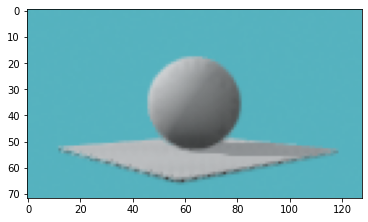

In [85]:
best_point = points[-1]
print(f"Best Point = {best_point[0]}, score = {best_point[1]}")
recovered_img = render_sun_dir(basic_render, best_point[0])
plt.imshow(recovered_img)

### Graphing Results

Point Cloud Documentation [here](http://www.open3d.org/docs/release/python_api/open3d.geometry.PointCloud.html#open3d-geometry-pointcloud).

#### Using Open3D

In [238]:
import open3d.visualization as viz

def o3d_plot(points, target):
  o3d_points=o3d.utility.Vector3dVector(points[:, 0])
  point_cloud = o3d.geometry.PointCloud(o3d_points)
  original_point = mesh.create_sphere(radius = .04, resolution = 2)
  original_point.translate(target, False)
  original_point.paint_uniform_color(helpers.convert_to_float([30, 10, 200]))

  point_cloud.paint_uniform_color(helpers.convert_to_float([100, 123, 60]))
  viz.draw_plotly([point_cloud, original_point], mesh_show_wireframe = False)

In [239]:
target = [0.577, -0.577, -0.577]
o3d_plot(points, target)

#### Using Matplotlib

In [375]:
# importing required libraries
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.ticker as plticker

def pyplot_3d(points, target, bounds = None, step = .5, minor = False, res = 150):
  """
  Graphs `points` in 3d using matplotlib.
  If `bounds` is specified, the x, y, and z axes fall within those bounds with ticks controlled by `step` and `minor`. Otherwise, the default scatter plot bounds are used.
  `points` is a list of 3-length arrays.
  `target` is a point (x,y,z), that is graphed as a star.
  `step` determines the tickmark intervals across the graph.
  `minor` controls if minor tick marks appear.
  """

  # transform tuple of points into n x 3 array of x, y, z coords
  point_coords = np.row_stack(points[:,0])
  vals = points[:, 1]

  viridis = mpl.colormaps['viridis'].resampled(8) # create colormap
  norm = mpl.colors.Normalize(vmin=vals[0], vmax=vals[-1]) # create normalization from the minimum and maximum values
  %matplotlib inline

  # creating figure
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  xs = point_coords[:,0]
  ys = point_coords[:,1]
  zs = point_coords[:,2]

  # creating the plot
  plot = ax.scatter(*target, color='#29438D', s = 100, marker = '*')
  ax.scatter(xs, ys, zs, s = 2, c = vals, norm = norm, cmap = viridis)


  # setting title and labels
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')

  # Limits and Ticks
  if bounds is not None:
    lower = bounds[0]
    higher = bounds[1]
    ax.set_xlim(lower,higher)
    ax.set_ylim(lower,higher)
    ax.set_zlim(lower,higher)

    loc = plticker.MultipleLocator(base = step) # puts ticks at regular intervals
    loc_minor = plticker.MultipleLocator(base = step/2) 
    
    # put major ticks
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.zaxis.set_major_locator(loc)

    if minor: # put minor ticks
      ax.xaxis.set_minor_locator(loc_minor)
      ax.yaxis.set_minor_locator(loc_minor)
      ax.zaxis.set_minor_locator(loc_minor)

  fig.suptitle("MCMC Inference over Possible Sunlight Directions", x = .57)
  # Creating Colorbar
  cb = fig.colorbar(plot, pad = .11)
  cb.set_label("Normalized Point Score", labelpad=10, size = 8)

  # displaying the plot
  plt.tight_layout()
  fig.set_dpi(res)
  plt.show()


Generate zoomed out and zoomed in Graphs

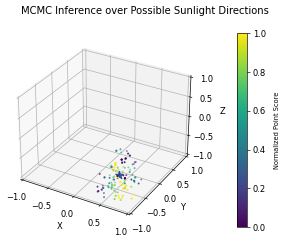

In [374]:
pyplot_3d(points, target, bounds = [-1, 1], res = 60) # zoom out

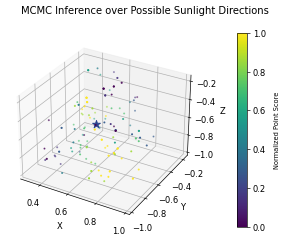

In [379]:
pyplot_3d(points, target, res = 60) # zoom in

# More Advanced Scene Inference (Plane with Scattered Objects)

## Generating Ground Truth Image

In [1]:
import os
os.environ['OPEN3D_CPU_RENDERING'] = 'true'

import open3d as o3d
import open3d.visualization as viz
import open3d.visualization.rendering as rendering
from matplotlib import pyplot as plt
import numpy as np

# Importing Helper Functions
import sys, os
sys.path.append('drive/MyDrive/Colab Notebooks/9.66 Final Project') # may not be needed depending where you're running this
import helpers

mesh = o3d.geometry.TriangleMesh # less typing
sd = (1280, 720)
low_quality = (256, 144)
very_low = (128, 72)

### Generating Scene Geometry

In [2]:
import random
from PIL import ImageColor
def translate_randomly(obj, range, scale = [1, 1, 1]):
  """
  Relatively transforms o3d objects in the specified `range`. Scales the transform by `scale`.
  Mutuates the original object.
  """
  pos = np.random.uniform(-range, range, size = 3) * np.asarray(scale)
  obj.translate(pos)


def make_complex_scene(num_cubes, num_cyls, num_cones, room_size = None, scene_size = (1280, 720)):
  """
  Generates a complex o3D scene with `num_cubes` cubes scattered, `num_cyls` cylinders scattered,
  and `num_cones` cones scattered across the scene. If `room_size` isn't none, generates an additional bounding box
  around the entire scene proportional to the amount of objects in it.
  
  Returns a two-length tuple, where the first element is the list of geometries and the second element is the Open3D `OffScreenRenderer`.
  """
  num_primatives = num_cubes + num_cyls + num_cones # used to scale the scene to give room
  translate_range = num_primatives / 2
  
  # Generate Baseline Plane
  plane = helpers.make_plane(num_primatives * 2)
  plane.translate([0,0,0], relative = False)
  
  # Generate other objects
  objects = [plane]
  
  # Generate Cubes
  for i in range(num_cubes): # make cubes
    params = tuple(np.random.uniform(0.75, 2.5, size = 3)) # random height, length, width
    box = mesh.create_box(*params)
    box.compute_vertex_normals(normalized = True)
    translate_randomly(box, translate_range, scale = [1, 0, 1]) # keep box "glued" to the ground
    
    objects.append(box)
  
  for i in range(num_cyls): # make cylinders
    params = tuple(np.random.uniform(.75, 2.5, size = 2))
    params[0] / 2 # radius shouldn't be that big

    cyl = mesh.create_cylinder(*params, resolution = 10)
    cyl.compute_vertex_normals(normalized = True)
    translate_randomly(cyl, translate_range, scale = [1, 0, 1])
    
    helpers.rotate_obj(cyl, -np.pi/2, 0, 0) # rotate so it's standing on top of plane
    cyl.translate([0, params[1]/2, 0]) # move cylinder so it's standing on top of plane
    objects.append(cyl)
    
  
  for i in range(num_cones): # make cones
    params = tuple(np.random.uniform(.75, 2.5, size = 2))
    params[0] / 2 # radius shouldn't be that big

    cone = mesh.create_cone(*params, resolution = 10)
    cone.compute_vertex_normals(normalized = True)
    translate_randomly(cone, translate_range, scale = [1, 0, 1])

    helpers.rotate_obj(cone, -np.pi/2, 0, 0)
    objects.append(cone)
    
  if (room_size is not None):
    # Generate "Room"
    room = mesh.create_box(num_primatives * room_size, num_primatives * room_size, num_primatives * room_size)
    room.translate([0,0,0], relative = False) # create a large box at the origin
    
    # invert vertex normals since we'll be seeing the inside of the box
    room.compute_vertex_normals(normalized = True)
    inverted_normals = np.asarray(room.vertex_normals) * -1
    room.vertex_normals = o3d.utility.Vector3dVector(inverted_normals)

    objects.append(room)
  
  # Apply Materials to everything
  colors = ["#4C75E9", "#4E9831", "#CA3338", "#FFFFFF"] # Hex code colors for random materials
  materials = []
  for color in colors:
    # create materials for each color (with max roughness)
    materials.append(helpers.create_material(ImageColor.getcolor(color, mode = "RGBA")))
  
  env = rendering.OffscreenRenderer(*scene_size)
  for i, obj in enumerate(objects):
    rand_material = random.choice(materials)
    env.scene.add_geometry(str(i), obj, rand_material)

  env.scene.set_lighting(rendering.Open3DScene.LightingProfile.MED_SHADOWS, (0.577, -0.577, -0.577)) # Testing

  camera_pos = np.array([2,4,1.75])
  zoom = .2

  env.setup_camera(30, [0,0,0], camera_pos / zoom, [0,1,0]) # sets up camera in (vertical_FOV, center, eye, up) format
  env.scene.set_background(helpers.convert_to_float([29, 25, 28, 255]))

  return objects, env

In [3]:
adv_scene = make_complex_scene(2,2,3, scene_size = very_low)
viz.draw_plotly(adv_scene[0], up = [0, 1, 0]) # y-up world

[Open3D INFO] EGL headless mode enabled.


### Lighting Scene Randomly

In [4]:
def rand_light_scene(env, range = 5, indir_light = 2000, rand_falloff = True, show_axes = False):
  """
  Randomly lights an open3D OffScreenRenderer `env` by turning down indirect light
  and placing a point light at a random location corresponding to `range`. If `rand_falloff` is True, the light's falloff will also be random.
  If `show_axes` is True, the axes of the scene will be shown on rendering to help debugging.

  Returns the point light's location, the point light's falloff, and the range of values passed in.
  """
  env.scene.scene.enable_sun_light(False) # Turn off sun light
  env.scene.scene.set_indirect_light_intensity(indir_light) # Turn down indirect lighting
  
  # remove existing random point in case this is run multiple times on same environment
  env.scene.scene.remove_light("rand_point")

  # randomize position
  rand_location = np.random.normal(loc = 0, scale = range, size = 3)
  y_pos = np.random.normal(loc = range / 2, scale = range / 2, size = 1)
  while y_pos < 0: # want y location to be positive
    y_pos = np.random.normal(loc = range / 2, scale = range / 2, size = 1)
  
  rand_location[1] = y_pos


  if rand_falloff:
    falloff = np.random.normal(loc = 40, scale = 20, size = 1)
    while falloff < 0:
      # falloff has to be greater than 0 or it doesn't make sense
      falloff = np.random.normal(loc = 40, scale = 20, size = 1)
  
  else:
    falloff = 60
  
  env.scene.scene.add_point_light("rand_point", [255,255,255], rand_location, 60000, falloff, True)
  env.scene.show_axes(show_axes) # debug
  return rand_location, falloff, range


[Open3D WARNING] Light rand_point is not in the scene graph
Light Location = [-1.90580195  3.95189141 -1.19363594], Light Falloff = [41.4083756]


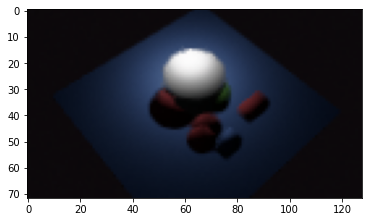

In [5]:
complex_env = adv_scene[1]
light_params = rand_light_scene(complex_env, indir_light = 500)
print(f"Light Location = {light_params[0]}, Light Falloff = {light_params[1]}")
truth_img_adv = complex_env.render_to_image()
plt.imshow(truth_img_adv)

## Using Metropolis Hastings to find the most likely point light position

In [6]:
from tqdm.notebook import tqdm # high-quality waiting

def point_light_mcmc(iterations:int, prior, likelihood, env, target:o3d.geometry.Image,
                     condition, rand_falloff = True, burn_in = 0):
  """
  Does MCMC over possible light positions and falloffs, using a `prior` and `likelihood` function.
  Draws `iterations` samples from the prior to do inference.
  
  Uses the passed in `env`, an Open3D OffScreenRenderer.
  
  `prior` should be a function that takes no arguments and returns a 3 length array for (x,y,z) position.
  `likelihood` should be a function that takes 3 arguments: `env`, a proposed state, and the target/truth state and computes the likelihood (or log likelihood)
  
  If `rand_falloff` is true, uses a random falloff for each sample in addition to position.
  `Condition` should be a function taking an output from `likelihood` and returning a boolean.
  Only the proportion of data after `burn_in` is included.
  """
  states = []
  current = prior(rand_falloff)
  curr_score = likelihood(env, current, target)

  
  #initialize to a state where `condition` is true
  print("Initializing...")
  for i in tqdm(range(iterations)):
    if condition(curr_score):
      break
    iterations -= 1
    current = prior(rand_falloff) # get a new random sample
    curr_score = likelihood(env, current, target)
  
  print("Done initializing!")

  for i in tqdm(range(iterations)):
    states.append((current, curr_score))
    # sample randomly from prior again
    move = prior(rand_falloff = rand_falloff)

    move_score = likelihood(env, move, target)

    # since bigger numbers mean a greater difference from the target, divide the current score by the move score
    acceptance = min(curr_score/move_score, 1)
    if (np.random.binomial(1, p=acceptance)) and condition(move_score):
      current = move
      curr_score = move_score # store current and curr_score after each iteration
  
  if not states:
    print("Unsucsessful.")
    return None
  
  delay = int(iterations * burn_in)
  data = np.asarray(states[delay:], dtype = "object") # only including data past the burn in, creating a matrix of n dimensions and 2 columns
  data = data[data[:, 1].argsort()] # sort data by score (2nd column)

  return data

In [7]:
def light_position_prior(rand_falloff = True, range = 5):
  rand_location = np.random.normal(loc = 0, scale = range, size = 3)
  y_pos = np.random.normal(loc = range / 2, scale = range / 2, size = 1)
  while y_pos < 0:
    y_pos = np.random.normal(loc = range / 2, scale = range / 2, size = 1) 

  rand_location[1] = y_pos

  if rand_falloff:
    falloff = np.random.normal(loc = 40, scale = 20, size = 1)
    while falloff < 0:
      # falloff has to be greater than 0 or it doesn't make sense
      falloff = np.random.normal(loc = 40, scale = 20, size = 1)
  
  else:
    falloff = 60

  return rand_location, falloff

def make_point_likelihood(grayscale = True, scale = 1):
  def __likelihood__(env, proposed, truth):
    prop_img = helpers.renderPointLight(env, proposed[0], falloff = float(proposed[1]))
    return helpers.gauss_image_likelihood(prop_img, truth, log = True, grayscale = True, scale = 1)
  return __likelihood__

In [8]:
point_lights = point_light_mcmc(100, light_position_prior, make_point_likelihood(), complex_env, truth_img_adv, lambda x:True)

Initializing...


  0%|          | 0/100 [00:00<?, ?it/s]

Done initializing!


  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
def show_best_result(point_lights, env):
  best_entry = point_lights[-1]
  best_pos, best_falloff = point_lights[-1][0]
  print(f"Best Position: {best_pos}\nBest Falloff: {best_falloff}\nScore = {best_entry[1]}")
  best_reconstruction = helpers.renderPointLight(env, pos = best_pos, falloff = best_falloff)
  plt.imshow(best_reconstruction)

Best Position: [-0.1662296   6.25192398 -1.87876462]
Best Falloff: [71.36375901]
Score = -1268306.4375220146


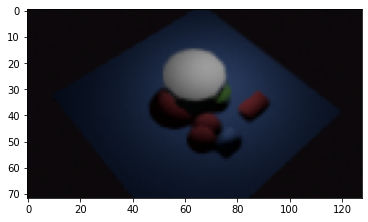

In [10]:
show_best_result(point_lights, complex_env)

## Doing Inference over a Bigger Scene

In [11]:
big_scene = make_complex_scene(8, 8, 8, scene_size = very_low)
big_scene_env = big_scene[1]

In [12]:
target_params = rand_light_scene(big_scene_env, indir_light = 500)

[Open3D WARNING] Light rand_point is not in the scene graph


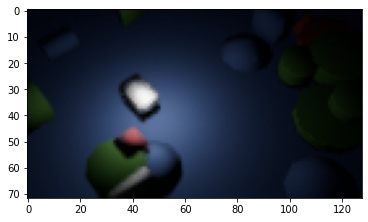

In [13]:
big_scene_img = big_scene_env.render_to_image()
plt.imshow(big_scene_img)

#### Creating a more complex condition

The previous condition let any image pass. Now, we want to only allow images that explain the scene beyond a threshold.

In [47]:
avg_pixels = True # setting global for if we're doing grayscale averaging or not

def make_condition(truth_img, threshold = 10):
  # find the "score" of the truth img to itself
  baseline = helpers.gauss_image_likelihood(truth_img, truth_img, log = True, grayscale = avg_pixels)
  return lambda x: abs(x/(baseline * threshold)) < 1

In [15]:
def light_position_prior_walk(mu_vec = None, rand_falloff = True, range = 5):
  if mu_vec is None:  
    rand_location = np.random.normal(loc = 0, scale = range, size = 3)
    y_pos = np.random.normal(loc = range / 2, scale = range / 2, size = 1) # notice that we can have negative numbers in our prior, it's just more likely the light's above ground
    rand_location[1] = y_pos

    while y_pos < 0:
      y_pos = np.random.normal(loc = range / 2, scale = range / 2, size = 1) 
  else: # transition function
    rand_location = np.zeros(3)
    for i,mu in enumerate(np.asarray(mu_vec).ravel()):
      # get output from truncated normal distribution for each mean in mu_vec
      rand_location[i] = np.random.normal(loc = mu, scale = 3, size = 1)

  if rand_falloff:
    falloff = np.random.normal(loc = 40, scale = 20, size = 1)
    while falloff < 0:
      # falloff has to be greater than 0 or it doesn't make sense
      falloff = np.random.normal(loc = 40, scale = 20, size = 1)
  
  else:
    falloff = 60

  return rand_location, falloff


In [16]:
point_likelihood = make_point_likelihood(scale = 1, grayscale = avg_pixels)
cond = make_condition(big_scene_img, 50)
adv_point_lights = point_light_mcmc(2000, light_position_prior, point_likelihood, big_scene_env, big_scene_img, cond)

-8468.93752201427 -423446.8761007135
Initializing...


  0%|          | 0/2000 [00:00<?, ?it/s]

Done initializing!


  0%|          | 0/1762 [00:00<?, ?it/s]

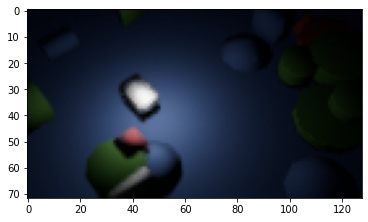

In [17]:
plt.imshow(big_scene_img)

Best Position: [-0.43943052  4.29477872  2.88381757]
Best Falloff: [63.14053565]
Score = -99773.43752201424


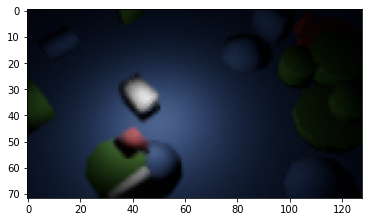

In [18]:
show_best_result(adv_point_lights, big_scene_env)

### Graphing Results

/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



[-0.62041782  3.73767349  2.89458825]


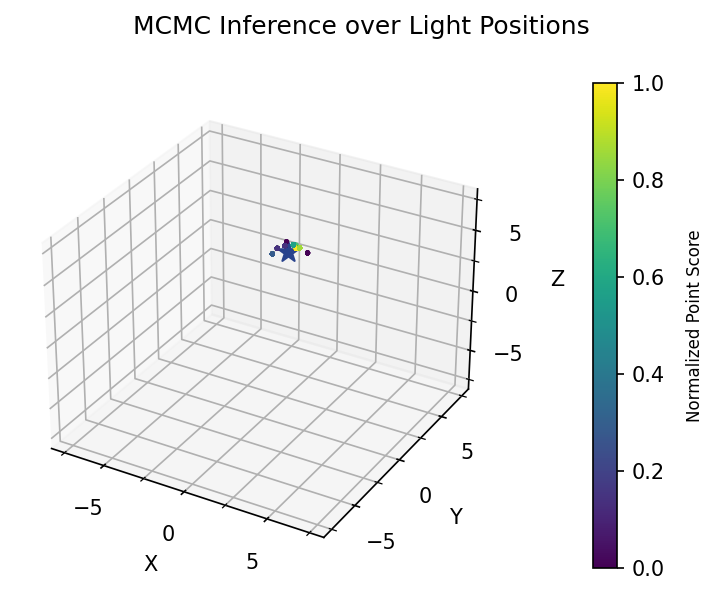

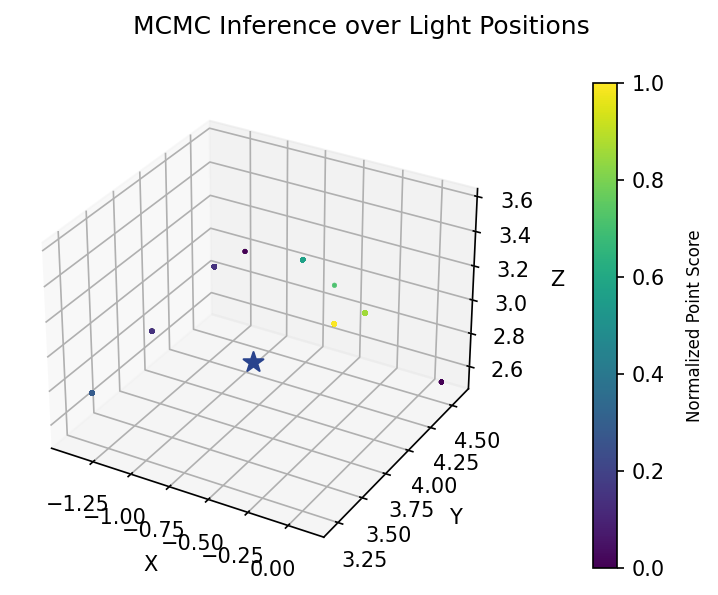

In [19]:
point_no_score = np.row_stack(adv_point_lights[:,0])
point_positions = np.row_stack(point_no_score[:, 0])

print(target_params[0])

helpers.pyplot_3d(point_positions, adv_point_lights[:, 1], target_params[0], bounds = [-8, 8], step = 5, minor = True) # plots intensities
helpers.pyplot_3d(point_positions, adv_point_lights[:, 1], target_params[0]) # plots intensities

In [75]:
vals = adv_point_lights[:, 1]
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.ticker as plticker

def o3d_plot(points, vals, target, geometries = []):
  viridis = mpl.colormaps['viridis'].resampled(8) # create colormap
  norm = mpl.colors.Normalize(vmin=vals[0], vmax=vals[-1]) # create normalization from the minimum and maximum values
  
  point_vec = o3d.utility.Vector3dVector()
  colors = o3d.utility.Vector3dVector()
  for i, point in enumerate(points): # insert points and their colors
    point_vec.append(point)
    colors.append(viridis(norm(vals[i]))[:3])

  point_cloud = o3d.geometry.PointCloud()
  point_cloud.points = point_vec
  point_cloud.colors = colors

  original_point= o3d.utility.Vector3dVector([target])
  original_point = o3d.geometry.PointCloud(original_point)
  original_point.paint_uniform_color(helpers.convert_to_float([0, 0, 0]))

  viz.draw_plotly([point_cloud, original_point] + geometries, mesh_show_wireframe = False, up = [0, 1, 0])

o3d_plot(point_positions, adv_point_lights[:,1], target_params[0], big_scene[0])